# Develop Training Strategy
Use the academy scenarios to develop a mixed training strategy. 
* Start easy with mechanics
* Add in more difficult scenarios while continuing to reinforce basic ideas
* Eventually add in the full match scenarios while keeping some of the competitive drills

I plan to develop some more specific defensive drills, so I'll pull from my fork of the GRF repo.

In [2]:
! sudo apt-get update
! sudo apt-get install git cmake build-essential libgl1-mesa-dev libsdl2-dev \
libsdl2-image-dev libsdl2-ttf-dev libsdl2-gfx-dev libboost-all-dev \
libdirectfb-dev libst-dev mesa-utils xvfb x11vnc libsdl-sge-dev python3-pip

! git clone -b v2.5 https://github.com/google-research/football.git
! cd football && pip3 install .

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,338 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InReleas

In [3]:
import gfootball.env as football_env
import matplotlib.pyplot as plt
import torch
from torch import nn
from collections import deque
import random
from tqdm.notebook import tqdm_notebook
import copy
import numpy as np

In [10]:
def get_env(scenarios, probas):
  scenario = np.random.choice(scenarios, p=probas)
  env = football_env.create_environment(env_name=scenario, 
                                        stacked=False, 
                                        logdir='/tmp/football', 
                                        representation='simple115',
                                        write_goal_dumps=False, 
                                        write_full_episode_dumps=False, 
                                        render=False)
  return env

env = get_env(list(SCENARIOS.keys()), np.ones(len(SCENARIOS.items())) / len(SCENARIOS.keys()))

In [53]:
SCENARIOS = {
    'academy_empty_goal_close':'basic',
    'academy_empty_goal':'basic',
    'academy_run_to_score':'basic',
    'academy_run_to_score_with_keeper':'easy',
    'academy_pass_and_shoot_with_keeper':'easy',
    'academy_run_pass_and_shoot_with_keeper':'medium',
    'academy_3_vs_1_with_keeper':'easy',
    'academy_corner':'medium',
    'academy_counterattack_easy':'medium',
    'academy_counterattack_hard':'hard',
    'academy_single_goal_versus_lazy':'easy',
    '11_vs_11_easy_stochastic':'hard',
    '11_vs_11_stochastic':'hard',
    # '11_vs_11_hard_stochastic':'xxhard'
}

### Build the Agent
Currently using the same type of DQN with replay buffer and target network. Made the hidden size larger and added an extra layer

In [54]:
HIDDEN_SIZE = 128
n_actions = env.action_space.n
obs_shape = env.observation_space.shape[0]

model = nn.Sequential(
  nn.Linear(obs_shape, HIDDEN_SIZE),
  nn.LeakyReLU(),
  nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
  nn.LeakyReLU(),
  nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
  nn.LeakyReLU(),
  nn.Linear(HIDDEN_SIZE, n_actions)
)

loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())
sync_freq = 100 # iter 

In [56]:
epochs = 250
losses = []
mem_size = 100
batch_size = 24
replay = deque(maxlen=mem_size)
h = 0
j = 0
epsilon = 0.1 # rate of exploration
gamma = 0.9   # discount for future values
scn = list(SCENARIOS.keys())

for i in tqdm_notebook(range(epochs), "Epoch"):
  probas = []
  for s, diff in SCENARIOS.items():
    if diff == 'basic':
      if i / epochs < 0.1:
        probas += [3]
      else:
        probas += [0]
    elif diff == 'easy':
      if i / epochs < 0.3:
        probas += [2]
      else:
        probas += [1]
    elif diff == 'medium':
      if i / epochs < 0.4:
        probas += [1]
      else:
        probas += [3]
    else:
      if i / epochs < 0.6:
        probas += [0]
      else:
        probas += [5]
  probas /= np.array(probas).sum()
  env = get_env(scn, probas=probas)

  obs, rew, done, info = env.step(1) # no action at first
  obs = torch.from_numpy(obs)
  while not done:
    j += 1
    qval = model(obs)
    if random.random() < epsilon:
      action_ = env.action_space.sample()
    else:
      action_ = qval.argmax().item()
    
    if done:
      break

    # make the move
    obs2, rew2, done2, info2 = env.step(action_)
    obs2 = torch.from_numpy(obs2)
    exp = (obs, action_, rew, obs2, done)
    replay.append(exp)
    obs = obs2
    rew = rew2
    done = done2

    if len(replay) > batch_size:
      minibatch = random.sample(replay, batch_size)
      state1_batch = torch.cat([s1.unsqueeze(0) for s1, a, r, s2, d in minibatch])
      action_batch = torch.Tensor([a for s1, a, r, s2, d in minibatch])
      reward_batch = torch.Tensor([r for s1, a, r, s2, d in minibatch])
      state2_batch = torch.cat([s2.unsqueeze(0) for s1, a, r, s2, d in minibatch])
      done_batch = torch.Tensor([d for s1, a, r, s2, d in minibatch])

      Q1 = model(state1_batch)
      with torch.no_grad():
        Q2 = model2(state2_batch)
      Y = reward_batch + gamma * ((1 - done_batch)) * torch.max(Q2, dim=1)[0]
      X = Q1.gather(dim=1, index=action_batch.long().unsqueeze(1)).squeeze()
      loss = loss_fn(X, Y.detach())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

      if j % sync_freq == 0:
        model2.load_state_dict(model.state_dict())

print(f"Finished {j+1} moves over {i+1} epochs.")


Finished 128579 moves over 250 epochs.


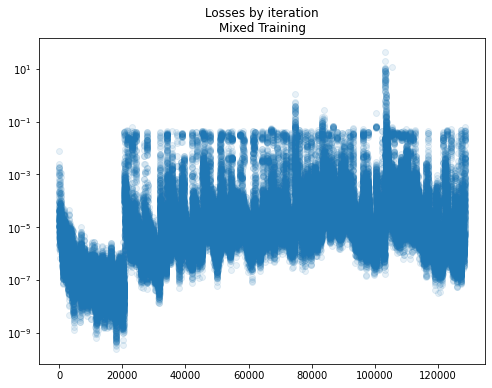

In [57]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(losses)), losses, alpha=0.1)
plt.title(f"Losses by iteration\nMixed Training")
plt.yscale('log')
plt.show()

This model is clearly quite good at the very basic scenarios (academy drills with few players, open goals, etc.), but there is a noisy lower bound to the performance with more difficult situations. However, with a final loss between 1e-4 and 1e-5, it's not *as bad* on full 11 vs. 11 football as I would think for a model of this size.

Probably time to add defensive scenarios and explore better modeling techniques.

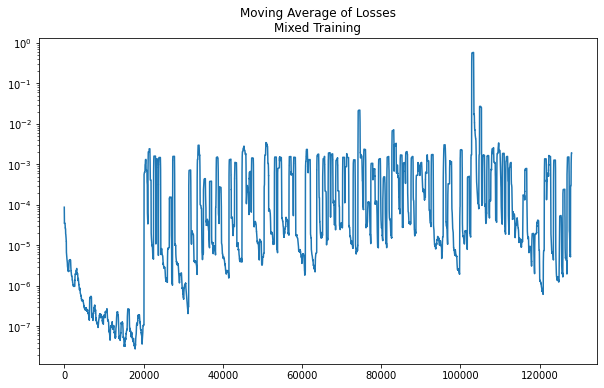

In [60]:
rolling_avg = []
window = 500
for i in range(len(losses)):
  if i >= window:
    rolling_avg.append(np.mean(losses[i-window:i]))

plt.figure(figsize=(10,6))
plt.plot(rolling_avg)
plt.title(f"Moving Average of Losses\nMixed Training")
plt.yscale('log')
plt.show()